In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq
from typing import Annotated, TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

In [3]:
llm = ChatGroq(model="llama-3.2-90b-text-preview")

In [4]:
class Candidate(BaseModel):
    name: str
    job_role: str

In [5]:
class State(TypedDict):
    history: Optional[str] = None
    candidate_name: Optional[str] = None
    role: Optional[str] = None
    total_questions: Optional[int] = None
    question: Optional[str] = None
    answer: Optional[str] = None

workflow = StateGraph(State)

In [6]:
prompt_extraction = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value.",
        ),
        ("human", "{text}"),
    ]
)

prompt_question = '''You are interviewer bot. Your name is Noha.
You need to interview a candidate for role of {role}.
This is a interview so far:
{history}\n
Ask your next question and dont repeat any question.'''

prompt_response = '''Check whether the answer given for asked question is correct or not.
Give a short response on it.
question: {question}
answer: {answer}'''

prompt_verdict = '''How do you feel about the overall interview given below?
{history}'''

In [7]:
def introduction(state: State):
    intro = "Hi, I am Noha, can you please introduce yourself and what you do?"
    print("Noha: ", intro)
    question = "question: "+intro
    return {"history":question,"question":question,"total_questions":1}

def handle_intro(state: State):
    history = state.get('history', '').strip()
    user_input = input("User: ")
    runnable = prompt_extraction | llm.with_structured_output(schema=Candidate)
    candidate = runnable.invoke({'text': user_input})
    return {"history":history+'\n'+"User: "+user_input,"candidate_name":candidate.name, "role":candidate.job_role}

def handle_question(state: State):
    history = state.get('history', '').strip()
    role = state.get('role', '').strip()

    prompt = prompt_question.format(role=role, history=history)
    question = llm.invoke(prompt).content
    print("Noha: ", question)
    return {"history":history+'\n'+question,"question":"question: "+question,"total_questions":state.get('total_questions')+1}

def handle_answer(state: State):
    history = state.get('history', '').strip()
    user_input = input("User: ")
    return {"history":history+'\n'+"User: "+user_input,"answer":user_input}

def handle_response(state: State):
    history = state.get('history', '').strip()
    question = state.get('question', '').strip()
    answer = state.get('answer', '').strip()

    prompt = prompt_response.format(question=question, answer=answer)
    response = llm.invoke(prompt).content
    print("Noha: ", response)
    return {"history":history+'\n'+response}

def handle_verdict(state: State):
    history = state.get('history', '').strip()

    prompt = prompt_verdict.format(history=history)
    verdict = "question: "+llm.invoke(prompt).content
    print("Noha: ",verdict)
    return {"history":history+'\n'+verdict, "total_questions":state.get('total_questions')}

In [8]:
def check_conv_length(state: State):
    if state.get('total_questions') < 5:
        return "handle_question"
    else:
        return "handle_verdict"

In [9]:
workflow.add_node("introduction", introduction)
workflow.add_node("handle_intro", handle_intro)
workflow.add_node("handle_question", handle_question)
workflow.add_node("handle_answer", handle_answer)
workflow.add_node("handle_response", handle_response)
workflow.add_node("handle_verdict", handle_verdict)

In [10]:
workflow.add_conditional_edges(
    "handle_response",
    check_conv_length,
    {"handle_question":"handle_question","handle_verdict":"handle_verdict"}
    )

workflow.add_edge(START, "introduction")
workflow.add_edge("introduction","handle_intro")
workflow.add_edge("handle_intro","handle_question")
workflow.add_edge("handle_question","handle_answer")
workflow.add_edge("handle_answer","handle_response")
workflow.add_edge("handle_verdict",END)

In [11]:
app = workflow.compile()

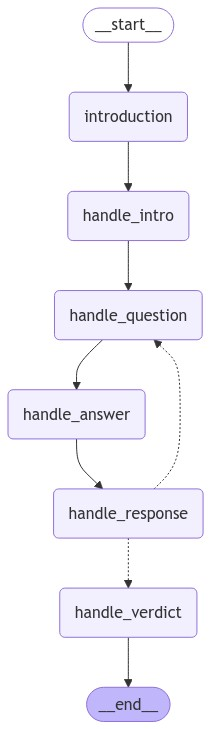

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
def stream_graph_updates(user_input: str):
    for event in app.stream({"answer": user_input}):
        for value in event.values():
            print("Noha:", value)

In [13]:
for event in app.stream({"history":'',"candidate_name":'',"role":'',"total_questions":0,"question":'',"answer":''}):
    pass

Hi, I am Noha, can you please introduce yourself?
{'introduction': {'history': 'question: Hi, I am Noha, can you please introduce yourself?', 'total_questions': 1, 'question': 'question: Hi, I am Noha, can you please introduce yourself?'}}
{'handle_intro': {'history': 'question: Hi, I am Noha, can you please introduce yourself?\nUser: I am aniket, being in the industry for last 4 years as a Data Scientist', 'candidate_name': 'Aniket', 'role': 'Data Scientist'}}
{'handle_question': {'history': "question: Hi, I am Noha, can you please introduce yourself?\nUser: I am aniket, being in the industry for last 4 years as a Data Scientist\nquestion: Hello Aniket, nice to meet you. With 4 years of experience as a Data Scientist, I'm sure you have worked on various projects. \n\nCan you walk me through one of your most challenging data science projects you've worked on, and how you overcame the obstacles you faced during that project?", 'total_questions': 2, 'question': "question: Hello Aniket, n

InvalidUpdateError: Must write to at least one of ['history', 'candidate_name', 'role', 'total_questions', 'question', 'answer']

In [ ]:
user_input = input("User: ")

app.update_state()

In [16]:
while True:
    user_input = input("User: ")
    
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

Hi, I am Noha, can you please introduce yourself?
Noha: {'history': 'question: Hi, I am Noha, can you please introduce yourself?', 'total_questions': 1, 'question': 'question: Hi, I am Noha, can you please introduce yourself?'}
Noha: {'history': "question: Hi, I am Noha, can you please introduce yourself?\nquestion: It's nice to meet you. Can you tell me a little bit about your background and how you think your skills and experience make you a strong fit for this role?", 'total_questions': 2, 'question': "question: It's nice to meet you. Can you tell me a little bit about your background and how you think your skills and experience make you a strong fit for this role?"}
The given answer "Hello" is incorrect. The correct answer should provide some information about the person's background, skills, and experience related to the role they're applying for.
Noha: {'history': 'question: Hi, I am Noha, can you please introduce yourself?\nquestion: It\'s nice to meet you. Can you tell me a lit

InvalidUpdateError: Must write to at least one of ['history', 'candidate_name', 'role', 'total_questions', 'question', 'answer']